## Gait Video Project
### Ablation Study on Cross generalization framework with Traditional ML models only 
* We will explore the performance of using feet coordinates only (merged from both front and side camera views), feet + ankle coordinates (merged from both front and side camera views), feet + ankle (merged from both front and side camera views) + knee (from the single front camera view) coordinates and all (feet + ankle (merged from both front and side camera views) + knee + hip (from the single front camera view)) coordinates on the traditional ML models.
* In our main traditional models, total 91 features (including the frame count and 90 CoV, range and asymmetry of the body coordinate features) were used.

In [11]:
from importlib import reload
from ml_utils.imports import *

from ml_utils import cross_gen_traditionalML
reload(cross_gen_traditionalML)
from ml_utils.cross_gen_traditionalML import extract_train_test_common_PIDs, compute_train_test_indices_split
from ml_utils.cross_gen_traditionalML import models, design, run_ml_models
from ast import literal_eval

In [12]:
path = 'C:\\Users\\Rachneet Kaur\\Box\\Gait Video Project\\GaitVideoData\\video\\'
data_path = path+'traditional_methods_dataframe.csv'
results_path = 'C:\\Users\\Rachneet Kaur\\Box\Gait Video Project\\AblationResults\\ML\\'

data = pd.read_csv(data_path, index_col= 0)
display(data.head())
        
#Whether to save the results (confusion matrices and RoC plots) or not 
save_results = True 

,key,cohort,trial,scenario,video,PID,stride_number,frame_count,label,right hip-x-CoV,...,ankle-z-asymmetry,heel-x-asymmetry,heel-y-asymmetry,heel-z-asymmetry,toe 1-x-asymmetry,toe 1-y-asymmetry,toe 1-z-asymmetry,toe 2-x-asymmetry,toe 2-y-asymmetry,toe 2-z-asymmetry
0,GVS_212_T_T1_1,HOA,BW,SLWT,GVS_212_T_T1,212,1,46,0,0.046077,...,14.426173,3.407379,10.662441,0.830365,0.502570,31.450487,8.644012,5.236678,31.182183,8.215725
1,GVS_212_T_T1_2,HOA,BW,SLWT,GVS_212_T_T1,212,2,39,0,0.021528,...,1.360847,5.155307,11.363806,4.333776,1.025647,28.266400,2.671081,6.678294,15.058825,4.903579
2,GVS_212_T_T1_3,HOA,BW,SLWT,GVS_212_T_T1,212,3,56,0,0.034394,...,1.341021,8.625363,7.159495,3.366152,1.759968,17.545787,5.921325,8.243491,9.578638,3.008162
3,GVS_212_T_T1_4,HOA,BW,SLWT,GVS_212_T_T1,212,4,53,0,0.028511,...,2.375934,6.728268,0.098235,0.999027,0.541911,7.843339,4.279617,0.748023,19.471731,5.086056
4,GVS_212_T_T1_5,HOA,BW,SLWT,GVS_212_T_T1,212,5,44,0,0.025213,...,8.525816,1.775282,0.033210,9.166863,1.354601,6.674183,8.479480,4.373622,0.315168,11.795593


In [13]:
#We are training on some subjects of trial W and testing on separate remaining subjects of trial WT
train_framework = 'W'
test_framework = 'WT'

#Extracting the list of PIDs/subjects that are only included in the training set, only included in the testing set 
#and common PIDs in both training and testing sets 
train_pids, test_pids, common_pids = extract_train_test_common_PIDs(data, train_framework, test_framework)
design()


Original number of subjects in training task W are: 32
Original number of subjects in testing task WT are: 26
Common number of subjects across train and test frameworks:  25
Common subjects across train and test frameworks:  [404, 405, 406, 407, 408, 409, 410, 411, 310, 311, 313, 314, 318, 320, 321, 322, 323, 212, 213, 214, 215, 216, 217, 218, 219]
Number of subjects only in training framework:  7
Subjects only in training framework:  [102, 112, 113, 115, 312, 123, 124]
Number of subjects only in test framework:  1
Subjects only in test framework:  [403]
******************************************


In [14]:
#Trial W for training 
trialW = data[data['scenario']==train_framework] #Full trial W with all 32 subjects 
#Trial WT for testing 
trialWT = data[data['scenario']==test_framework] #Full trial WT with all 26 subjects 

#Full training data stats 
print ('Number of subjects in trial W in each cohort:\n', trialW.groupby('PID').first()['cohort'].value_counts())
print('Strides in complete training set: ', len(trialW))
print ('HOA, MS and PD strides in complete training set:\n', trialW['cohort'].value_counts())
design()

#Full testing data stats 
print ('Number of subjects in trial WT in each cohort:\n', trialWT.groupby('PID').first()['cohort'].value_counts())
print('Strides in complete testing set: ', len(trialWT))
print ('HOA, MS and PD strides in complete testing set:\n', trialWT['cohort'].value_counts())
design()

#Training only data with strides from W
train_only_trialW = trialW[trialW.PID.isin(train_pids)] #subset of trial W with subjects only present in trial W but not in trial WT
print ('Number of subjects only in trial W in each cohort:\n', train_only_trialW.groupby('PID').first()['cohort'].value_counts())
print('Strides of subjects only in trial W: ', len(train_only_trialW))
print ('HOA, MS and PD strides in of subjects only in trial W :\n', train_only_trialW['cohort'].value_counts())
design()

#Testing only data with strides from WT
test_only_trialWT = trialWT[trialWT.PID.isin(test_pids)] #subset of trial WT with subjects only present in trial WT but not in trial W
print ('Number of subjects only in trial WT in each cohort:\n', test_only_trialWT.groupby('PID').first()['cohort'].value_counts())
print('Strides of subjects only in trial WT: ', len(test_only_trialWT))
print ('HOA, MS and PD strides in of subjects only in trial WT :\n', test_only_trialWT['cohort'].value_counts())
design()

#Training data with strides from W for common PIDs in trials W and WT
train_trialW_commonPID = trialW[trialW.PID.isin(common_pids)] #subset of trial W with common subjects in trial W and WT
print ('Number of subjects common to trials W and WT in each cohort:\n', train_trialW_commonPID.groupby('PID').first()['cohort'].value_counts())
print('Strides in trial W in each cohort of subjects common to trials W and WT: ', len(train_trialW_commonPID))
print ('HOA, MS and PD strides in trial W of subjects common to trials W and WT:\n', train_trialW_commonPID['cohort'].value_counts())
design()

#Testing data with strides from WT for common PIDs in trials W and WT
test_trialWT_commonPID = trialWT[trialWT.PID.isin(common_pids)] #subset of trial W with common subjects in trial W and WT
print ('Number of subjects common to trials W and WT in each cohort:\n', test_trialWT_commonPID.groupby('PID').first()['cohort'].value_counts())
print('Strides in trial WT in each cohort of subjects common to trials W and WT: ', len(test_trialWT_commonPID))
print ('HOA, MS and PD strides in trial WT of subjects common to trials W and WT:\n', test_trialWT_commonPID['cohort'].value_counts())
design()

Number of subjects in trial W in each cohort:
 HOA    14
MS     10
PD      8
Name: cohort, dtype: int64
Strides in complete training set:  1380
HOA, MS and PD strides in complete training set:
 HOA    658
MS     389
PD     333
Name: cohort, dtype: int64
******************************************
Number of subjects in trial WT in each cohort:
 PD     9
MS     9
HOA    8
Name: cohort, dtype: int64
Strides in complete testing set:  1050
HOA, MS and PD strides in complete testing set:
 PD     367
HOA    351
MS     332
Name: cohort, dtype: int64
******************************************
Number of subjects only in trial W in each cohort:
 HOA    6
MS     1
Name: cohort, dtype: int64
Strides of subjects only in trial W:  372
HOA, MS and PD strides in of subjects only in trial W :
 HOA    324
MS      48
Name: cohort, dtype: int64
******************************************
Number of subjects only in trial WT in each cohort:
 PD    1
Name: cohort, dtype: int64
Strides of subjects only in trial 

In [15]:
cols_to_drop = ['key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label', 'PID']
X_train_common = train_trialW_commonPID.drop(cols_to_drop, axis = 1)
Y_train_common = train_trialW_commonPID[['PID', 'label']]

train_test_concatenated = pd.concat([trialW, trialWT], axis = 0).reset_index().drop('index', axis = 1)

#Shuffling the concatenated data
train_test_concatenated = shuffle(train_test_concatenated, random_state = 0)

#Computing the X (91 features), Y (PID, label) for the models 
X_full = train_test_concatenated.drop(cols_to_drop, axis=1)
Y_full = train_test_concatenated[['PID', 'label']]
print (X_full.shape, Y_full.shape) #1176+1651

#Computing the training and test set indices for the CV folds 
train_indices, test_indices = compute_train_test_indices_split(train_test_concatenated, X_train_common, Y_train_common, \
                                                               train_pids, test_pids, train_framework, test_framework)
framework = 'task_and_subject_WtoWT' #Defining the task generalization framework of interest

(2430, 91) (2430, 2)


In [16]:
ml_models = ['logistic_regression', 'decision_tree']
# ['logistic_regression', 'random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  \
#              'linear_svm', 'mlp']

feet_features = [s for s in data.columns if any(x in s for x in ['toe', 'heel'])]
print ('Number of feet features = ', len(feet_features))

ankle_features = [s for s in data.columns if 'ankle' in s]
print ('Number of ankle features = ', len(ankle_features))

knee_features = [s for s in data.columns if 'knee' in s]
print ('Number of knee features = ', len(knee_features))

hip_features = [s for s in data.columns if 'hip' in s]
print ('Number of hip features = ', len(hip_features))

frame_count_feature = ['frame_count']
print ('The extra frame count feature is added to all datastreams')

#The three extra data streams we would need to run for (assuming we already have the results for the 
#fourth feet+ankle+knee+hip+frame count = All features)
datastreams = {'feet': feet_features + frame_count_feature, 'feet+ankle': feet_features + ankle_features + frame_count_feature, \
               'feet+ankle+knee': feet_features + ankle_features + knee_features + frame_count_feature}

print ('No. of features explored in each datastream: ', {x:len(datastreams[x]) for x in datastreams})
ablation_columns = list(itertools.product(ml_models,datastreams))
metrics = pd.DataFrame(columns = ablation_columns) #Dataframe to store accuracies for each ML model for raw data 

Number of feet features =  45
Number of ankle features =  15
Number of knee features =  15
Number of hip features =  15
The extra frame count feature is added to all datastreams
No. of features explored in each datastream:  {'feet': 46, 'feet+ankle': 61, 'feet+ankle+knee': 76}


feet
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.39392048863102813, 0.43713277192219413, 0.39392048863102813, 0.47084078681284797, [0.40600664043694074, 0.3657962647016225, 0.5395954106280193], 0.4155237676980083, 0.39392048863102813, 0.39392048863102813, [0.5569025368519808, 0.48293876550560744, 0.20673000073643677], 0.382639733666879, 0.39392048863102813, 0.3796946784196387, [0.46050551105283544, 0.3937180362899908, 0.2936956536578107], 0.6471544476442781, 0.6517699863312543]

Stride-based model performance (standard deviation):  [0.09890461658439652, 0.05579934281054954, 0.09890461658439652, 0.03216070179963878, [0.19766679962713088, 0.17265408634835736, 0.13159939586099914], 0.10080360308901287, 0.09890461658439652, 0.09890461658439652, [0.1999664900397239, 0.24810329349513857, 0.03227801079398144], 0.09702857747360115, 0.09890461658439652, 0.08312484941159345, [0.19344209255998984, 0.19495742923992304, 0.026

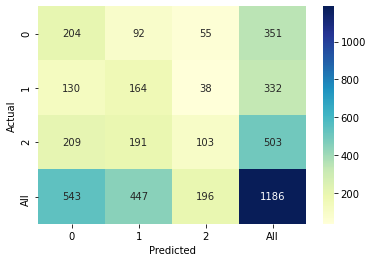

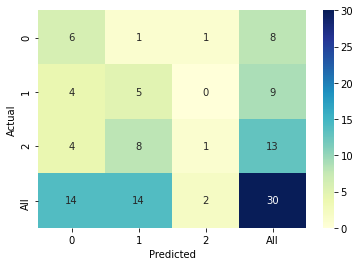

<Figure size 432x288 with 0 Axes>

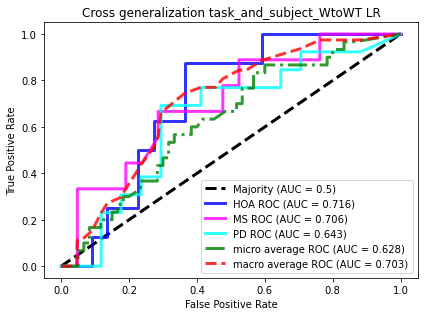

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 18}

Stride-based model performance (mean):  [0.38835402739957053, 0.4051750273389567, 0.38835402739957053, 0.4443780495755608, [0.3905216017003792, 0.2765755074567607, 0.5484279728597302], 0.3988144143882637, 0.38835402739957053, 0.38835402739957053, [0.6089346155473556, 0.33542073368521325, 0.2520878939322222], 0.36845869545202453, 0.38835402739957053, 0.37806003492966617, [0.4674988607902031, 0.29954431755380695, 0.3383329080120636], 0.5289698039211606, 0.5342860785848156]

Stride-based model performance (standard deviation):  [0.058971630230517, 0.05737305368479886, 0.058971630230517, 0.0665009749228374, [0.1443860523654185, 0.13965759849746423, 0.174114346473425], 0.060024782216809264, 0.058971630230517, 0.058971630230517, [0.134632212226805, 0.18959809223244903, 0.12493788121755238], 0.06624340144890578, 0.058971630230517, 0.06486320537693026, [0.13295249192378983, 0.1567214

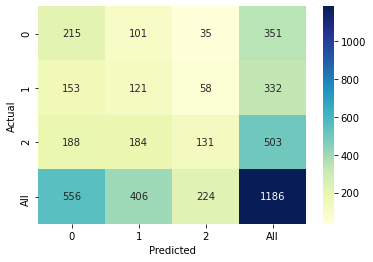

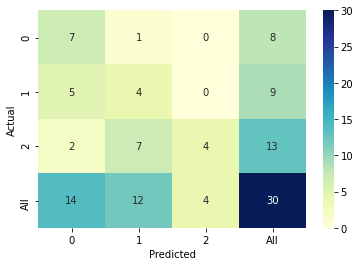

<Figure size 432x288 with 0 Axes>

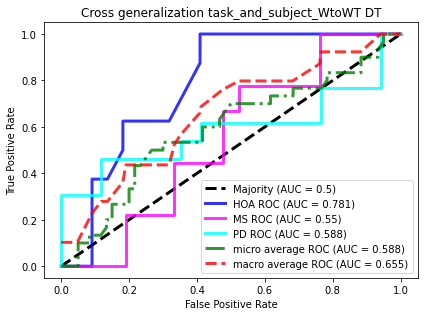

********************************
********************************
feet+ankle
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.3683917314801549, 0.3954998779314974, 0.3683917314801549, 0.43045238765905347, [0.3613765720740674, 0.33266888340417755, 0.49245417831624727], 0.3882701170495552, 0.3683917314801549, 0.3683917314801549, [0.4804192583060126, 0.47790932122411556, 0.2064817716185375], 0.3553937664001523, 0.3683917314801549, 0.3535408000136856, [0.40680806407604775, 0.38007384112510656, 0.2792993939993026], 0.6018900996654801, 0.606970498595249]

Stride-based model performance (standard deviation):  [0.08637745490805794, 0.04010166394803115, 0.08637745490805794, 0.05976994089475038, [0.1584500762697475, 0.1507853877624319, 0.2057925073631828], 0.08637423976421667, 0.08637745490805794, 0.08637745490805794, [0.16432534626609244, 0.23197040280427317, 0.11472355592156067], 0.08030178362943122, 0.08637745490805793, 0.07

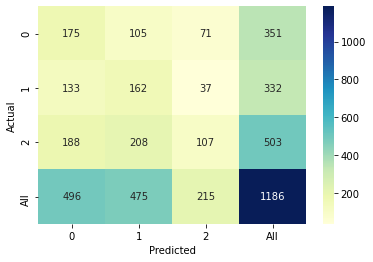

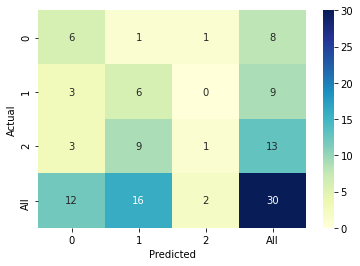

<Figure size 432x288 with 0 Axes>

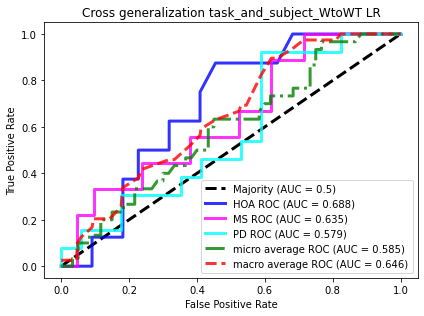

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 36}

Stride-based model performance (mean):  [0.36123977100792504, 0.40402493958628966, 0.36123977100792504, 0.4481741261869999, [0.34955018287278794, 0.29226822562967075, 0.5702564102564103], 0.381475080515042, 0.36123977100792504, 0.36123977100792504, [0.5784450893449883, 0.37218908717013455, 0.19379106503000307], 0.34419127371365577, 0.36123977100792504, 0.3448830879672103, [0.42812454653281284, 0.32565485020304297, 0.27879442440511143], 0.5270928814333757, 0.5322660496500484]

Stride-based model performance (standard deviation):  [0.06693125004409786, 0.04480869715514839, 0.06693125004409786, 0.08850721402496682, [0.15679227923130096, 0.11000424990647456, 0.21524586869467355], 0.07079907100887557, 0.06693125004409786, 0.06693125004409786, [0.21443799036101066, 0.15932321896597387, 0.10795290378020413], 0.06451964877219143, 0.06693125004409786, 0.061755746609617246, [0.17384446

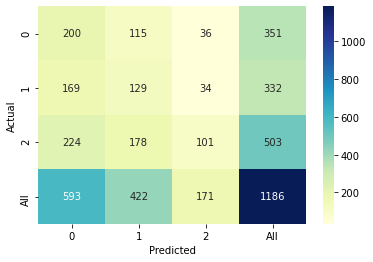

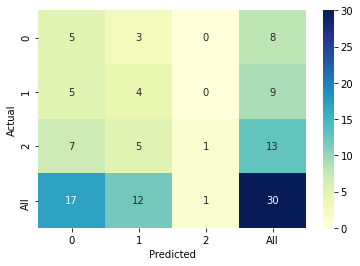

<Figure size 432x288 with 0 Axes>

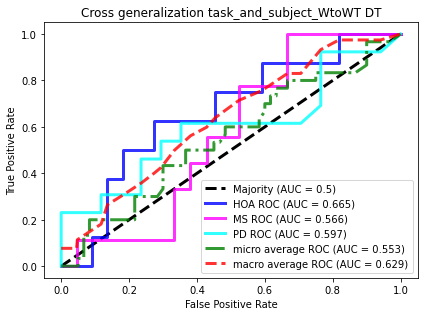

********************************
********************************
feet+ankle+knee
logistic_regression
best_params:  {'logisticregression__random_state': 0}

Stride-based model performance (mean):  [0.4133311176785025, 0.44280589272626936, 0.4133311176785025, 0.4817194529239829, [0.3707373926886122, 0.34445206490903396, 0.6132282205811618], 0.4216664682405318, 0.4133311176785025, 0.4133311176785025, [0.463041129188753, 0.47373429000998324, 0.3282239855228592], 0.40463921034246797, 0.41333111767850256, 0.4153025786429896, [0.4019462847207228, 0.38974455349165305, 0.42222679281502806], 0.6221234543489789, 0.629397565352758]

Stride-based model performance (standard deviation):  [0.07747890564472061, 0.07018242116016479, 0.07747890564472061, 0.07785741229430744, [0.1650749491842554, 0.11943511625532342, 0.15929022589125355], 0.07852898335178565, 0.07747890564472061, 0.07747890564472061, [0.11105750204634866, 0.23583393709225997, 0.10130645548114692], 0.08040915068007441, 0.0774789056447206

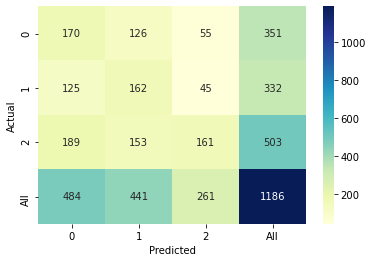

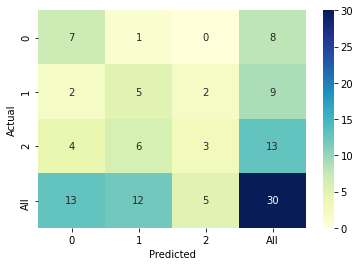

<Figure size 432x288 with 0 Axes>

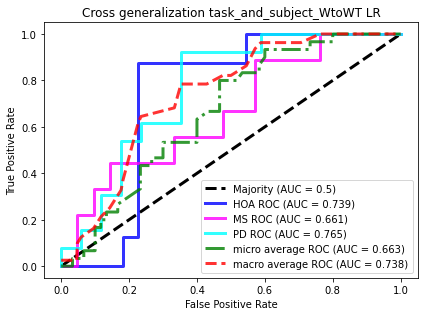

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 44}

Stride-based model performance (mean):  [0.4141366538468567, 0.44126232452612796, 0.4141366538468567, 0.48541828561828043, [0.3516222356882593, 0.3313722155890831, 0.6407925223010414], 0.41668947002548445, 0.4141366538468567, 0.4141366538468567, [0.5415837415028517, 0.35311471109382936, 0.35536995747977246], 0.4040128921591193, 0.4141366538468567, 0.42062513295916154, [0.42030240265787794, 0.33966683580115936, 0.4520694380183206], 0.5672756744054843, 0.5729692431530661]

Stride-based model performance (standard deviation):  [0.07162743331235906, 0.05487989960745738, 0.07162743331235906, 0.0637113077210706, [0.15938222247139722, 0.10966237798801887, 0.13063812045024828], 0.07358613000928908, 0.07162743331235906, 0.07162743331235906, [0.20436540536278258, 0.13639763254292764, 0.08057772990980347], 0.07192770502749532, 0.07162743331235906, 0.06218351711007151, [0.176304166756795

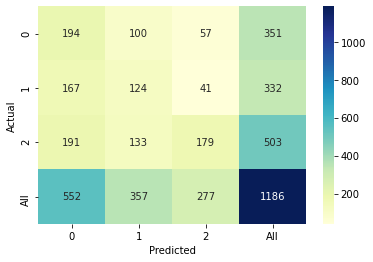

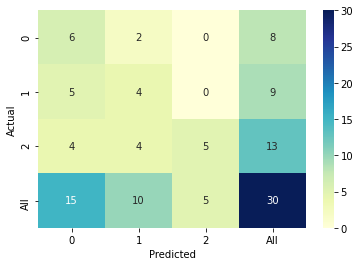

<Figure size 432x288 with 0 Axes>

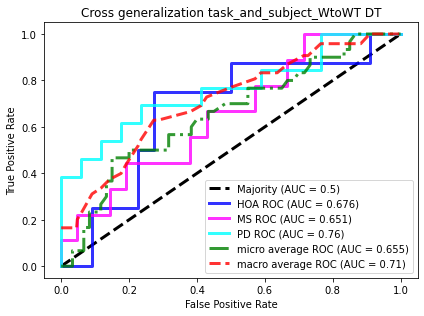

********************************
********************************


In [17]:
for col in datastreams:
    print (col)
    datastream = datastreams[col]
#     print (regressN_trainX_norm[datastream].head())
    stride_person_metrics = run_ml_models(ml_models, X_full[datastream], Y_full, train_indices, test_indices, framework, results_path, save_results, col)
    for i in stride_person_metrics.columns:
        metrics[(i, col)] = stride_person_metrics[i]
    print ('********************************')

if save_results:
    metrics.to_csv(results_path+ framework + '\\cross_generalize_ablation_study_'+framework+'_result_metrics.csv')

In [18]:
metrics

,"(logistic_regression, feet)","(logistic_regression, feet+ankle)","(logistic_regression, feet+ankle+knee)","(decision_tree, feet)","(decision_tree, feet+ankle)","(decision_tree, feet+ankle+knee)"
stride_accuracy_mean,0.393920,0.368392,0.413331,0.388354,0.361240,0.414137
stride_precision_macro_mean,0.437133,0.395500,0.442806,0.405175,0.404025,0.441262
stride_precision_micro_mean,0.393920,0.368392,0.413331,0.388354,0.361240,0.414137
stride_precision_weighted_mean,0.470841,0.430452,0.481719,0.444378,0.448174,0.485418
stride_precision_class_wise_mean,"[0.40600664043694074, 0.3657962647016225, 0.53...","[0.3613765720740674, 0.33266888340417755, 0.49...","[0.3707373926886122, 0.34445206490903396, 0.61...","[0.3905216017003792, 0.2765755074567607, 0.548...","[0.34955018287278794, 0.29226822562967075, 0.5...","[0.3516222356882593, 0.3313722155890831, 0.640..."
stride_recall_macro_mean,0.415524,0.388270,0.421666,0.398814,0.381475,0.416689
stride_recall_micro_mean,0.393920,0.368392,0.413331,0.388354,0.361240,0.414137
stride_recall_weighted_mean,0.393920,0.368392,0.413331,0.388354,0.361240,0.414137
stride_recall_class_wise_mean,"[0.5569025368519808, 0.48293876550560744, 0.20...","[0.4804192583060126, 0.47790932122411556, 0.20...","[0.463041129188753, 0.47373429000998324, 0.328...","[0.6089346155473556, 0.33542073368521325, 0.25...","[0.5784450893449883, 0.37218908717013455, 0.19...","[0.5415837415028517, 0.35311471109382936, 0.35..."
stride_F1_macro_mean,0.382640,0.355394,0.404639,0.368459,0.344191,0.404013


### Reading the final metrics from the saved file

In [19]:
ablation_cross_generalize = pd.read_csv(results_path+ framework + '\\cross_generalize_ablation_study_'+framework+'_result_metrics.csv')
ablation_cross_generalize.index = ablation_cross_generalize['Unnamed: 0']
ablation_cross_generalize.drop('Unnamed: 0', axis = 1, inplace = True)

ablation_cross_generalize.columns = [literal_eval(ablation_cross_generalize.loc['person_accuracy_mean'].index[idx]) for idx in range(len(ablation_cross_generalize.loc['person_accuracy_mean'].index))]

In [20]:
ablation_cross_generalize

,"(logistic_regression, feet)","(logistic_regression, feet+ankle)","(logistic_regression, feet+ankle+knee)","(decision_tree, feet)","(decision_tree, feet+ankle)","(decision_tree, feet+ankle+knee)"
Unnamed: 0,,,,,,
stride_accuracy_mean,0.39392048863102813,0.3683917314801549,0.4133311176785025,0.38835402739957053,0.36123977100792504,0.4141366538468567
stride_precision_macro_mean,0.43713277192219413,0.3954998779314974,0.44280589272626936,0.4051750273389567,0.40402493958628966,0.44126232452612796
stride_precision_micro_mean,0.39392048863102813,0.3683917314801549,0.4133311176785025,0.38835402739957053,0.36123977100792504,0.4141366538468567
stride_precision_weighted_mean,0.47084078681284797,0.43045238765905347,0.4817194529239829,0.4443780495755608,0.4481741261869999,0.48541828561828043
stride_precision_class_wise_mean,"[0.40600664043694074, 0.3657962647016225, 0.53...","[0.3613765720740674, 0.33266888340417755, 0.49...","[0.3707373926886122, 0.34445206490903396, 0.61...","[0.3905216017003792, 0.2765755074567607, 0.548...","[0.34955018287278794, 0.29226822562967075, 0.5...","[0.3516222356882593, 0.3313722155890831, 0.640..."
stride_recall_macro_mean,0.4155237676980083,0.3882701170495552,0.4216664682405318,0.3988144143882637,0.381475080515042,0.41668947002548445
stride_recall_micro_mean,0.39392048863102813,0.3683917314801549,0.4133311176785025,0.38835402739957053,0.36123977100792504,0.4141366538468567
stride_recall_weighted_mean,0.39392048863102813,0.3683917314801549,0.4133311176785025,0.38835402739957053,0.36123977100792504,0.4141366538468567
stride_recall_class_wise_mean,"[0.5569025368519808, 0.48293876550560744, 0.20...","[0.4804192583060126, 0.47790932122411556, 0.20...","[0.463041129188753, 0.47373429000998324, 0.328...","[0.6089346155473556, 0.33542073368521325, 0.25...","[0.5784450893449883, 0.37218908717013455, 0.19...","[0.5415837415028517, 0.35311471109382936, 0.35..."


### Heatmap for person mean accuracy for all algorithms and data streams for Cross generalize W->WT

In [22]:
person_accuracy_cross_generlaize = pd.DataFrame(columns = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp'], index = list(datastreams.keys()))


for idx in range(len(ablation_cross_generalize.columns)):
    x = ablation_cross_generalize.loc['person_accuracy_mean'].index[idx][1]
    y = ablation_cross_generalize.loc['person_accuracy_mean'].index[idx][0]
#     print (regressN_metrics.loc['person_accuracy'][(y, x)])
    person_accuracy_cross_generlaize.loc[x, y] = ablation_cross_generalize.loc['person_accuracy_mean'][(y, x)]

person_accuracy_cross_generlaize = person_accuracy_cross_generlaize.astype(float)

In [23]:
#Adding the person mean accuracy for all the models using all the features 
person_accuracy_cross_generlaize.loc['All features'] = [np.nan]*9

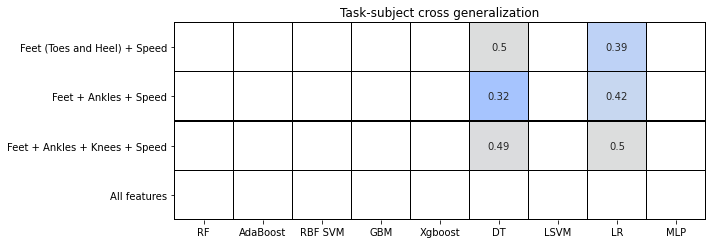

In [26]:
ml_model_names1 = ['RF','AdaBoost', 'RBF SVM', 'GBM','Xgboost', 'DT',  'LSVM', 'LR', 'MLP']
datasets = ['Feet (Toes and Heel) + Speed', 'Feet + Ankles + Speed', 'Feet + Ankles + Knees + Speed', 'All features']

fig, axes = plt.subplots(1, 1, figsize=(10, 3.5))
sns.heatmap(person_accuracy_cross_generlaize, vmin=0, vmax=1.0, center = 0.5, cmap="coolwarm", annot=True, linewidths=0.4, linecolor="k", \
            cbar = False, xticklabels=ml_model_names1,  yticklabels=datasets)
plt.title('Task-subject cross generalization')
plt.tight_layout()
plt.savefig(results_path + framework + '\\cross_generalize_ablation_study_'+framework+'_heatmap.jpg', dpi = 250)
plt.show()